In [2]:
# import required libraries
from random import random
from tkinter.ttk import LabelFrame
import numpy as np
print('numpy version:',np.__version__)
from turtle import color
import pandas as pd
import matplotlib.ticker as ytick
print('pandas version:',pd.__version__)
import seaborn as sns 
import matplotlib.pyplot as plt




numpy version: 1.21.5
pandas version: 1.4.2


In [3]:
# file path
case_data = "loan.csv"
loan = pd.read_csv(case_data, low_memory=False)
print(loan.shape)

(39717, 111)


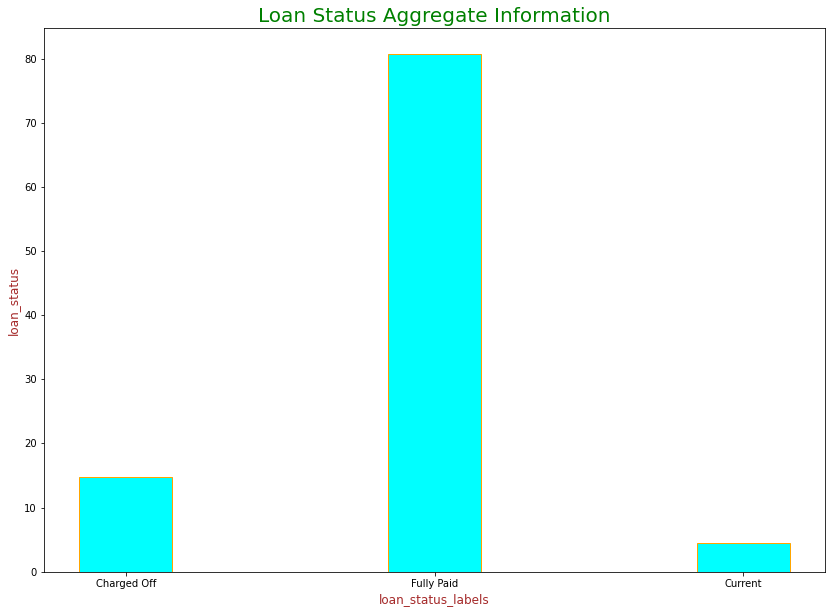

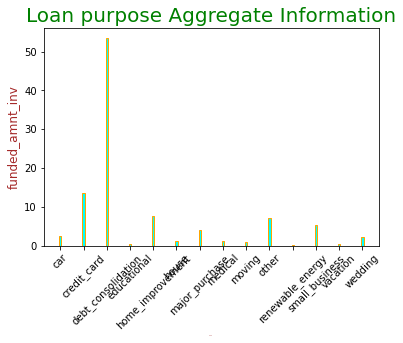

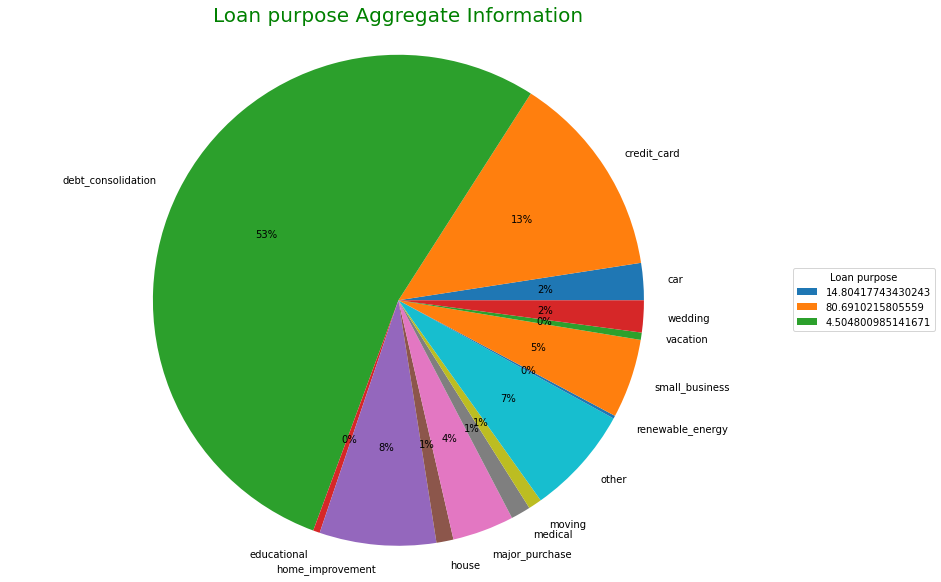

In [4]:
# plotting a bar chart for three types of loan_status

chargedOff = loan.loc[(loan["loan_status"] == "Charged Off")]
current = loan.loc[(loan["loan_status"] == "Current")]
fullyPaid = loan.loc[(loan["loan_status"]== "Fully Paid")]
data  = [{"Charged Off": chargedOff["funded_amnt_inv"].sum(), "Fully Paid":fullyPaid["funded_amnt_inv"].sum(), "Current":current["funded_amnt_inv"].sum()}]
inv_total = pd.DataFrame(data) 
plt.figure(figsize=(14, 10))
chargedOffSum = float(inv_total["Charged Off"])
fullyPaidSum = float(inv_total["Fully Paid"])
currentSum = float(inv_total["Current"])
total_sum=chargedOffSum+fullyPaidSum+currentSum
chargedOffSumPer=chargedOffSum/total_sum*100
fullyPaidSumPer=fullyPaidSum/total_sum*100
currentSumPer=currentSum/total_sum*100
loan_status = [chargedOffSumPer,fullyPaidSumPer,currentSumPer]
loan_status_labels = 'Charged Off','Fully Paid','Current'
plt.xlabel("loan_status_labels",fontdict={'fontsize':12,'fontweight':5,'color':'Brown'})
plt.ylabel("loan_status",fontdict={'fontsize':12,'fontweight':5,'color':'Brown'})
plt.bar(loan_status_labels,loan_status, width=0.3, edgecolor='Orange', align='center',color='cyan')
plt.title('Loan Status Aggregate Information',fontdict={'fontsize':20,'fontweight':5,'color':'GREEN'})
plt.show()

# plotting bar chart for different types of loan purpose
loans_purpose = loan.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()
laon_pupose_percentage=(loans_purpose["funded_amnt_inv"]/loans_purpose["funded_amnt_inv"].sum())*100
plt.xlabel("purpose",fontdict={'fontsize':1,'fontweight':0.1,'color':'Brown'})
plt.ylabel("funded_amnt_inv",fontdict={'fontsize':12,'fontweight':5,'color':'Brown'})
plt.bar(loans_purpose["purpose"],laon_pupose_percentage, width=0.1, edgecolor='Orange', align='center',color='cyan')
plt.title('Loan purpose Aggregate Information',fontdict={'fontsize':20,'fontweight':5,'color':'GREEN'})
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

# plotting pie chart for different types of purpose
loans_purpose = loan.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()
plt.figure(figsize=(14, 10))
plt.pie(loans_purpose["funded_amnt_inv"],labels=loans_purpose["purpose"],autopct='%1.0f%%')

plt.title('Loan purpose Aggregate Information',fontdict={'fontsize':20,'fontweight':5,'color':'GREEN'})
plt.axis('equal')
plt.legend(loan_status,title="Loan purpose",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


In [5]:
# DATA CLEANING
# completely, hence remove all columns having no values
# Remove the columns not required

loan = loan.dropna(axis=1, how="all")
print(loan.info(max_cols=200))
columnsnot_required = ["id", "member_id", "funded_amnt", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record", "revol_bal", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "tax_liens", "application_type", "pub_rec_bankruptcies", "addr_state"]
loan.drop(columnsnot_required, axis=1, inplace=True)

# We have 10+ years the most for emp_length, 
# but remove the rows with null values
loan.dropna(axis=0, subset=["emp_length"], inplace=True)
# remove NA rows for revol_util
loan.dropna(axis=0, subset=["revol_util"], inplace=True)
# Need to remove the rows with loan_status as "Current"
loan = loan[loan["loan_status"].apply(lambda x:False if x == "Current" else True)]

# update loan_status as Fully Paid to 0 and Charged Off to 1
loan["loan_status"] = loan["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)
# update emp_length feature with continuous values as int where less 1 year= 0 and 10+ =10 
loan["emp_length"] = pd.to_numeric(loan["emp_length"].apply(lambda x:0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

# look through the purpose value counts
loan_purpose_values = loan["purpose"].value_counts()*100/loan.shape[0]
# remove rows with less than 1% of value counts in paricular purpose 
loan_purpose_delete = loan_purpose_values[loan_purpose_values<1].index.values
loan = loan[[False if p in loan_purpose_delete else True for p in loan["purpose"]]]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [6]:
#Deriving Metrices
#Date formatting
from datetime import datetime

def formatdate(datetime):
    year = datetime.split("-")[0]
    if(len(year) == 1):
        datetime = "0"+datetime
    return datetime

loan['issue_d'] = loan['issue_d'].apply(lambda x:formatdate(x))
loan['issue_d'] = loan['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y'))
# extracting month and year from issue_date
loan['month'] = loan['issue_d'].apply(lambda x: x.month)
print(loan['month'])
loan['year'] = loan['issue_d'].apply(lambda x: x.year)
print(loan['year'])

loan["earliest_cr_line"] = pd.to_numeric(loan["earliest_cr_line"].apply(lambda x:x.split('-')[1]))
print(loan["earliest_cr_line"])

0        12
1        12
2        12
3        12
5        12
         ..
39712     7
39713     7
39714     7
39715     7
39716     6
Name: month, Length: 36388, dtype: int64
0        2011
1        2011
2        2011
3        2011
5        2011
         ... 
39712    2007
39713    2007
39714    2007
39715    2007
39716    2007
Name: year, Length: 36388, dtype: int64
0        85
1        99
2         1
3        96
5         4
         ..
39712    90
39713    86
39714    98
39715    88
39716     3
Name: earliest_cr_line, Length: 36388, dtype: int64


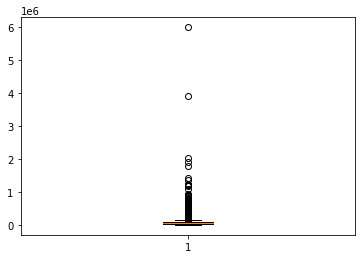

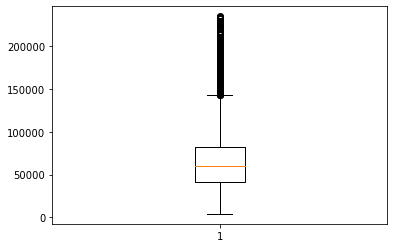

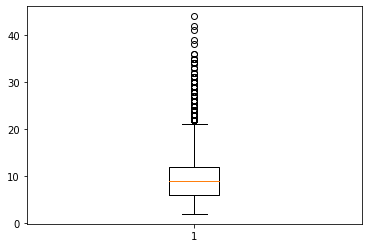

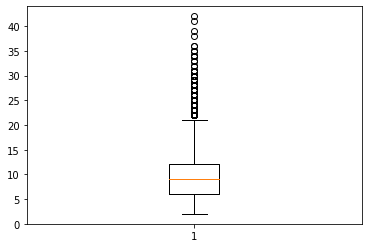

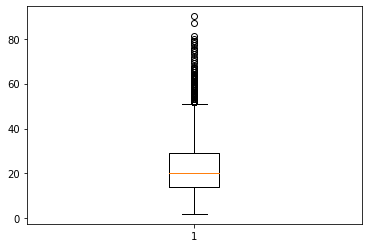

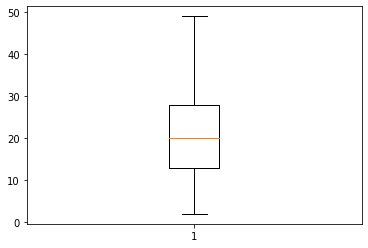

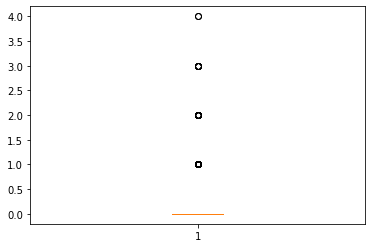

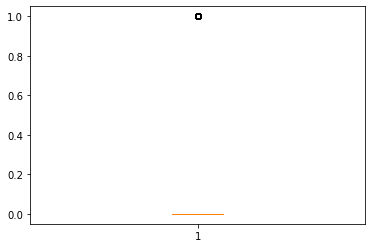

<bound method NDFrame.describe of        loan_amnt  funded_amnt_inv        term int_rate  installment grade  \
0           5000           4975.0   36 months   10.65%       162.87     B   
1           2500           2500.0   60 months   15.27%        59.83     C   
2           2400           2400.0   36 months   15.96%        84.33     C   
3          10000          10000.0   36 months   13.49%       339.31     C   
5           5000           5000.0   36 months    7.90%       156.46     A   
...          ...              ...         ...      ...          ...   ...   
39712       2500           1075.0   36 months    8.07%        78.42     A   
39713       8500            875.0   36 months   10.28%       275.38     C   
39714       5000           1325.0   36 months    8.07%       156.84     A   
39715       5000            650.0   36 months    7.43%       155.38     A   
39716       7500            800.0   36 months   13.75%       255.43     E   

      sub_grade  emp_length home_ownershi

In [7]:
# Outliers treatments
#To remove the outliers, we can use IQR method (Q1–1.5*IQR to Q3+1.5*IQR) 
# we need to remomve outliers from annual_inc i.e. 99 to 100%
plt.boxplot(loan["annual_inc"])
plt.show()
annual_inc_q = loan["annual_inc"].quantile(0.99)
loan = loan[loan["annual_inc"] < annual_inc_q]
plt.boxplot(loan["annual_inc"])
plt.show()
# #To remove the outliers, we can use IQR method (Q1–1.5*IQR to Q3+1.5*IQR) 
# we need to remomve outliers from open_acc i.e. 99.9 to 100%
plt.boxplot(loan["open_acc"])
plt.show()
open_acc_q = loan["open_acc"].quantile(1.0)
loan = loan[loan["open_acc"] < open_acc_q]
plt.boxplot(loan["open_acc"])
plt.show()
# To remove the outliers, we can use IQR method (Q1–1.5*IQR to Q3+1.5*IQR) 
# we need to remomve outliers from total_acc i.e. 98 to 100%
plt.boxplot(loan["total_acc"])
plt.show()
total_acc_q = loan["total_acc"].quantile(0.98)
loan = loan[loan["total_acc"] < total_acc_q]
plt.boxplot(loan["total_acc"])
plt.show()
##To remove the outliers, we can use IQR method (Q1–1.5*IQR to Q3+1.5*IQR)
# we need to remomve outliers from pub_rec i.e. 99.5 to 100%
plt.boxplot(loan["pub_rec"])
plt.show()
pub_rec_q = loan["pub_rec"].quantile(0.995)
loan = loan[loan["pub_rec"] <= pub_rec_q]
plt.boxplot(loan["pub_rec"])
plt.show()

# Data after cleaning

print(loan.describe)

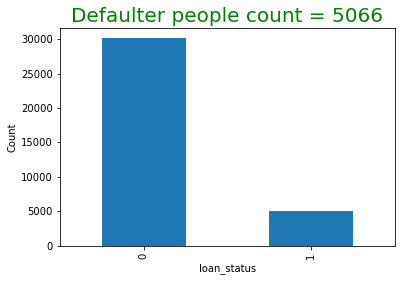

In [8]:
# Check for amount of defaults in the data using barplot
defaulter=loan["loan_status"].value_counts()

loan["loan_status"].value_counts().plot.bar(xlabel="loan_status", ylabel="Count")
plt.title('Defaulter people count = '+str(defaulter[1]),fontdict={'fontsize':20,'fontweight':5,'color':'GREEN'})
plt.show()

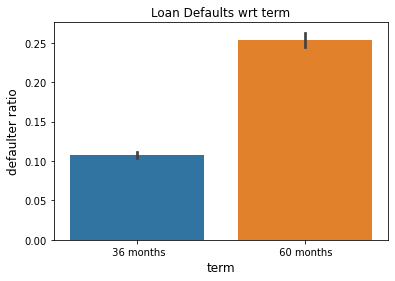

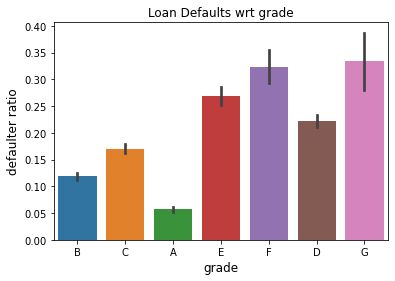

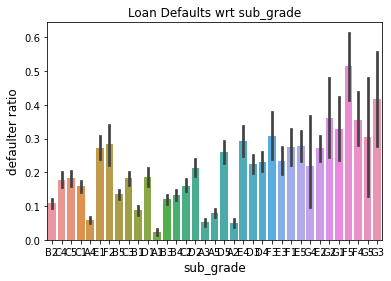

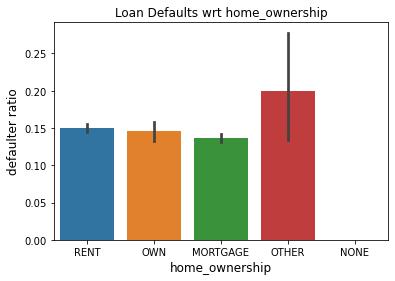

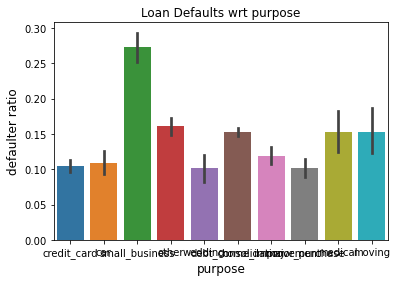

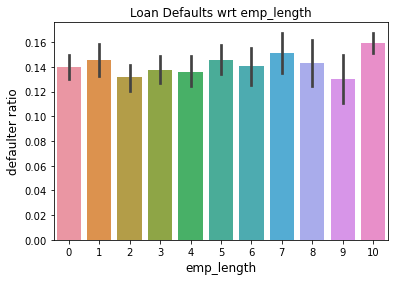

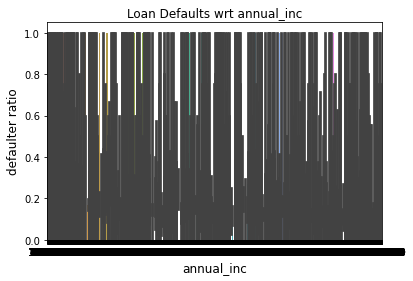

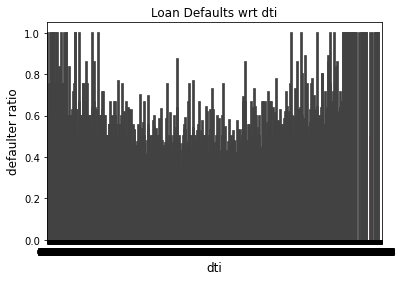

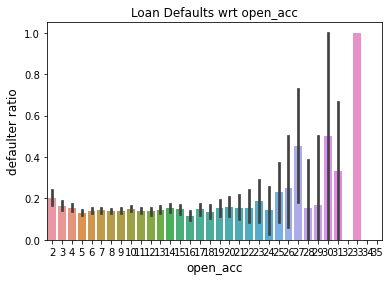

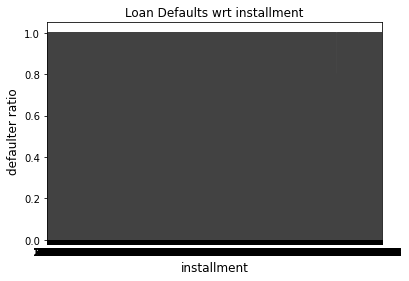

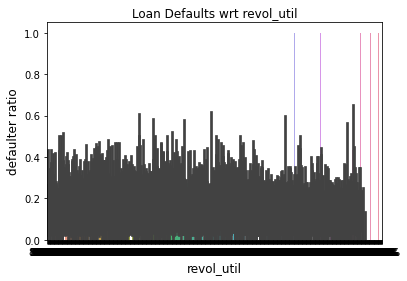

In [9]:
#univariate plots
def univariateBarPlot(x):
    sns.barplot(x=x, y='loan_status', data=loan)
    plt.title("Loan Defaults wrt "+str(x))
    plt.xlabel(x, fontsize=12)
    plt.ylabel("defaulter ratio", fontsize=12)

# check for defaulters wrt term 
univariateBarPlot("term")
plt.show()

# check for defaulters wrt grade
univariateBarPlot("grade")
plt.show()

# check for defaulters wrt sub_grade 
univariateBarPlot("sub_grade")
plt.show()

# check for defaulters wrt home_ownership
univariateBarPlot("home_ownership")
plt.show()
# check for defaulters wrt purpose 
univariateBarPlot("purpose")
plt.show()

# check for defaulters wrt emp_length 
univariateBarPlot("emp_length")
plt.show()

# check for defaulters wrt month 
univariateBarPlot("month")
#plt.show()
# check for defaulters wrt year 
univariateBarPlot("year")
#plt.show()
# check for defaulters wrt int_rate
univariateBarPlot("int_rate")
#plt.show()
# check for defaulters wrt annual_inc
univariateBarPlot("annual_inc")
plt.show()
# check for defaulters wrt dti
univariateBarPlot("dti")
plt.show()
# check for defaulters wrt open_acc
univariateBarPlot("open_acc")
plt.show()
# check for defaulters wrt installment
univariateBarPlot("installment")
plt.show()
# check for defaulters wrt revol_util 
univariateBarPlot("revol_util")
plt.show()

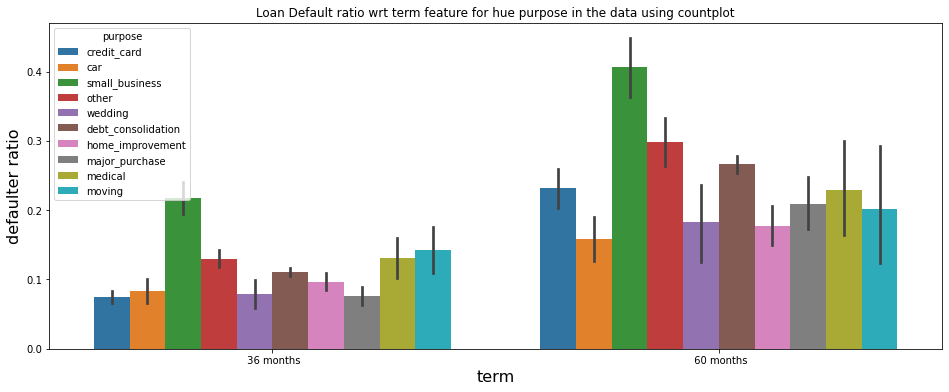

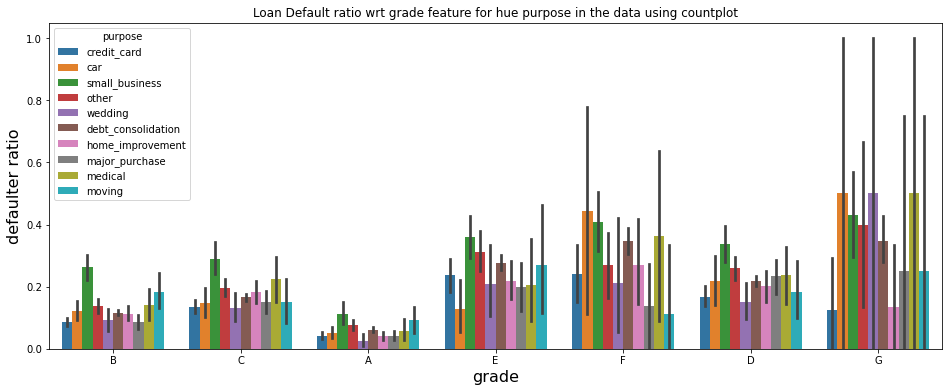

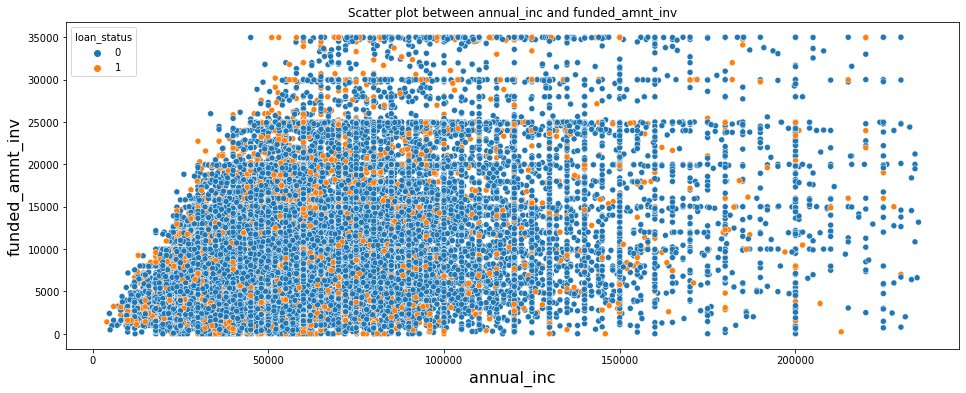

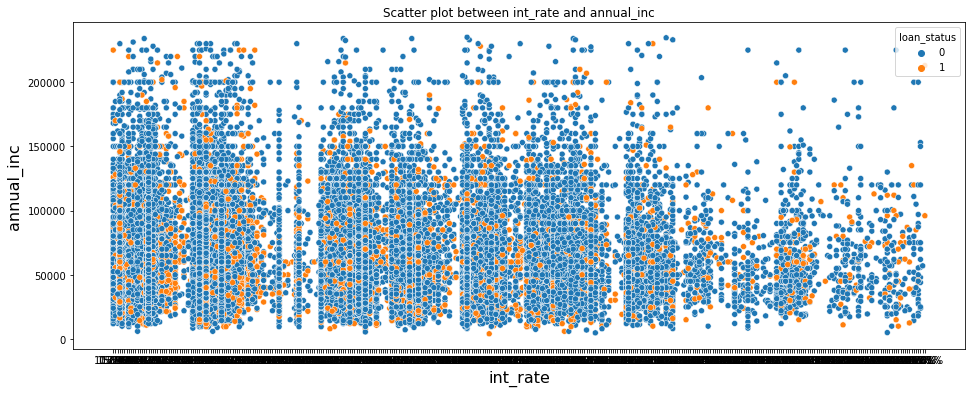

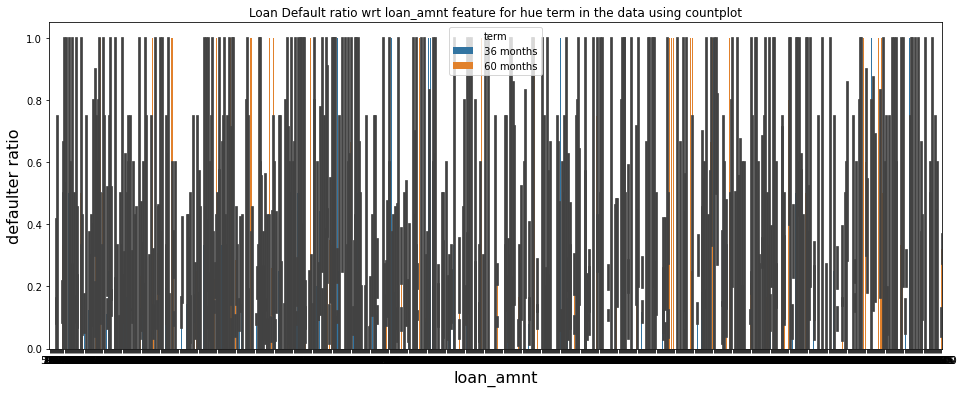

In [10]:
#Bivariate plots

# function to plot scatter plot for two features
def plotScatter(x, y):
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, hue="loan_status", data=loan)
    plt.title("Scatter plot between "+x+" and "+y)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    
def plotBivariateBar(x, hue, figsize=(16,6)):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y='loan_status', hue=hue, data=loan)
    plt.title("Loan Default ratio wrt "+x+" feature for hue "+hue+" in the data using countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()


# check for defaulters wrt term and purpose in the data 
plotBivariateBar("term", "purpose")

# check for defaulters wrt grade and purpose in the data 
plotBivariateBar("grade", "purpose")

# plot scatter for funded_amnt_inv with annual_inc
plotScatter("annual_inc", "funded_amnt_inv")

# plot scatter for int_rate with annual_inc
plotScatter("int_rate", "annual_inc")

# check for defaulters wrt loan_amnt_range and term in the data
plotBivariateBar("loan_amnt", "term")


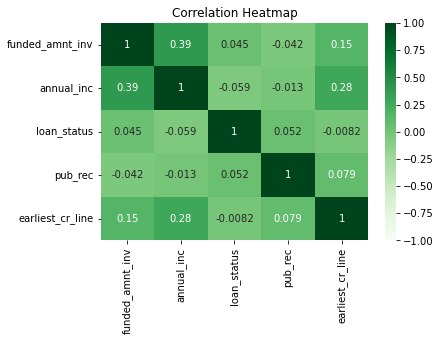

In [11]:
# plot heat map to see correlation between features
continuous_f = ["funded_amnt_inv", "annual_inc", "term", "int_rate", "loan_status", "revol_util", "pub_rec", "earliest_cr_line"]
loan_corr = loan[continuous_f].corr()
sns.heatmap(loan_corr,vmin=-1.0,vmax=1.0,annot=True, cmap = "Greens")
plt.title("Correlation Heatmap")
plt.show()